# Select images based on similarity
One way to select more data is taking an image which caused a mistake in your neural network, and finding similar images to that one. Although you can browse a lot of recordings yourself, you can also try to find images which elicit a similar response in your neural network. 

In this notebook I will show a simple way of doing this with a VGG16 neural network. 

In [1]:
# Get the imports needed for this project. 
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.neighbors import NearestNeighbors
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
import cv2
import os
import tqdm

## Create a neural network with pre-trained weights
As a neural network I will take a VGG16 neural network with a global maxpooling operator on top. The global max pooling ensures we have a feature vector of 512 features as output of the neural network. 

In [2]:
vgg16 = VGG16(weights='imagenet', include_top=False)
model = tf.keras.Sequential(layers=[vgg16, tf.keras.layers.GlobalMaxPool2D() ])

## Analyse your unannotated data
To select from your annotated data it's important to get inference results from the neural network we built, and store those in a list which links the filenames to the features. 

In [ ]:
# Build a database with all imags, except for the last 1000 
folder = '/datasets/mappilary_scrape/images'
filename_features = list()

In [4]:
images_to_select = os.listdir(folder)[:len(os.listdir(folder)) - 1000]
already_existing = set([x[0] for x in filename_features])
images_to_select = [x for x in images_to_select if not x in already_existing]

print("To go: ", len(images_to_select))

def get_features_from_image(filename):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)    
    return features, img


# Get the features for the images and store both the filename and features in a list

for image_filename in tqdm.tqdm(images_to_select):
    img_path = os.path.join(folder , image_filename)
    features, img = get_features_from_image(img_path)
    filename_features.append((image_filename, features[0,:]))

  0%|          | 0/306131 [00:00<?, ?it/s]

To go:  306131


 24%|██▍       | 74947/306131 [1:41:01<5:11:35, 12.37it/s]


KeyboardInterrupt: 

## Build an index with the metrics
Now that we have the features for all unannotated images we can build a datastructure with all features. Here I offer two choices: a nearest neighbors algorithm using euclidian distance with an efficient datastructure, and a brute-force algorithm with cosine similarity between images. Experiment away!

In [5]:
X = np.array([x[1] for x in filename_features])
#nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X)
nbrs = NearestNeighbors(n_neighbors=4, algorithm='brute', metric='cosine').fit(X)

## Data selection

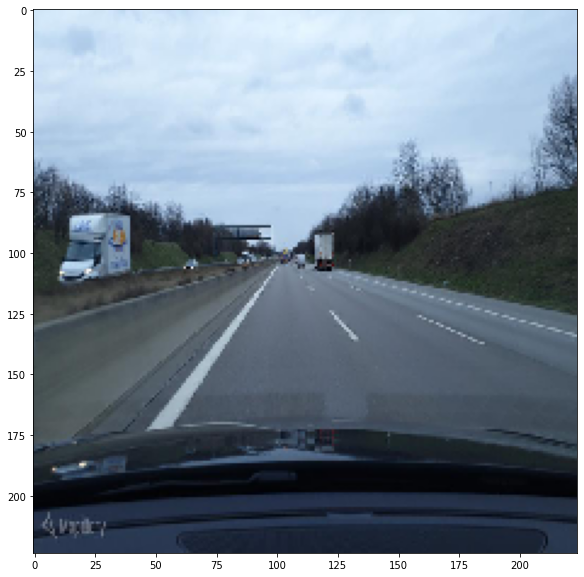

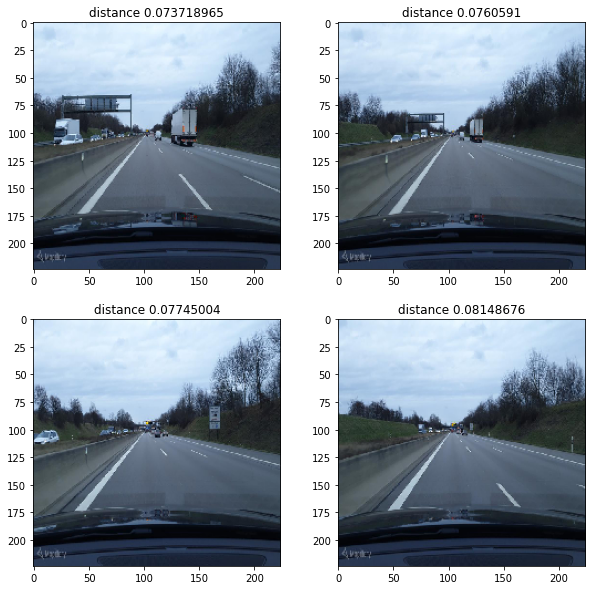

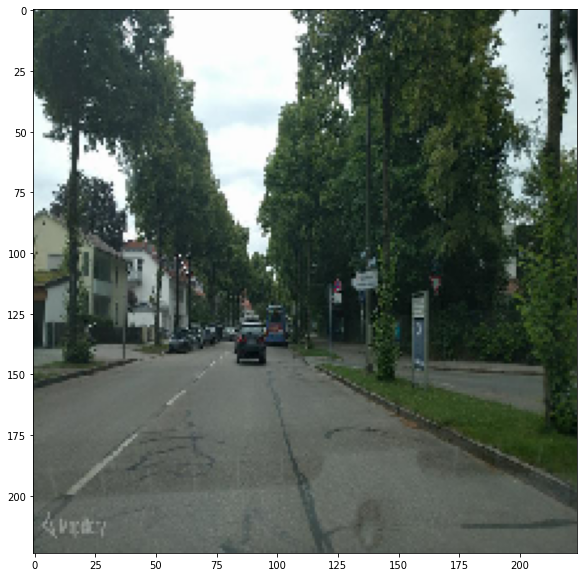

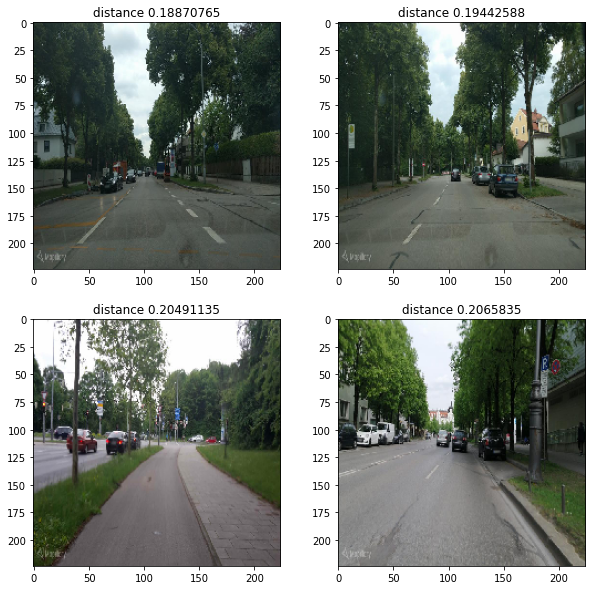

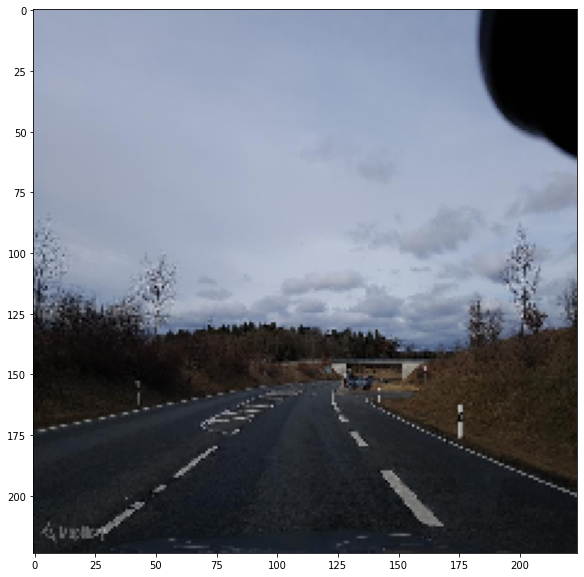

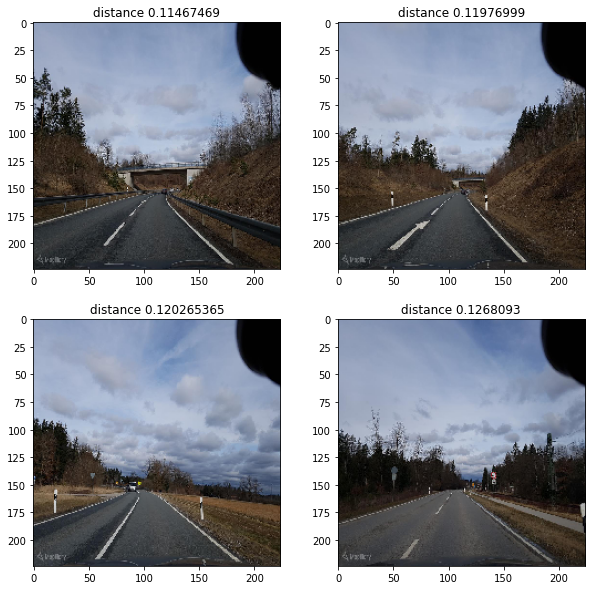

In [6]:
for image_filename in os.listdir(folder)[-3:]:
    img_path = os.path.join(folder , image_filename)
    features, img = get_features_from_image(img_path)
    distances, indices = nbrs.kneighbors([features[0,:]])
   
    ## Show the query image
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()

    ## Show the closest matching results
    result_index = 0
    f, axarr = plt.subplots(len(distances[0])//2,2, figsize=(10,10))
    for distance, index in zip(distances[0], indices[0]):
        img_path = os.path.join(folder , filename_features[index][0])
        result = image.load_img(img_path, target_size=(224, 224))
        axarr[result_index//2,result_index%2].imshow(result)
        axarr[result_index//2,result_index%2].set_title('distance ' + str(distance))
        result_index += 1
    plt.show()

## What does the algorithm select? 
The last question now is 'what is the algorithm actually looking at'? That's a difficult question. You might like an image because it contains a specific traffic sign, but the algorithm mostly pays attention to a bike in front of the car. 

One way of doing this is showing the 'saliency' of the neural network. It's a bit hard to understand what the neural network pays attention to, because the output is a feature vector. What we can do in this case is visualise the saliency for individual features. Below I do that for multiple features. 

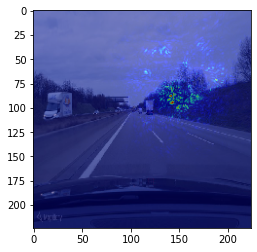

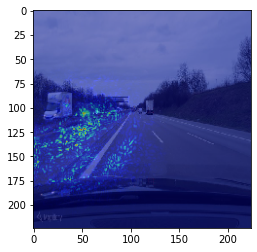

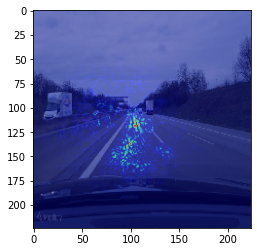

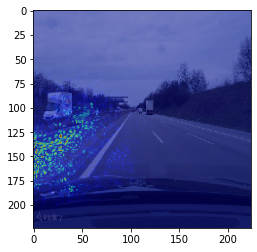

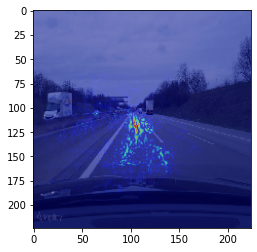

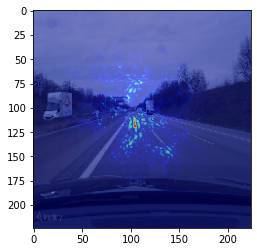

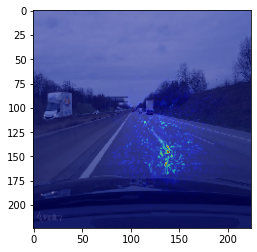

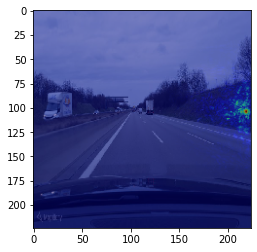

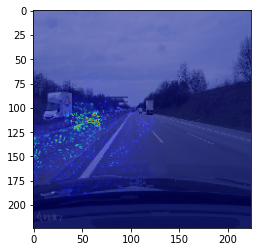

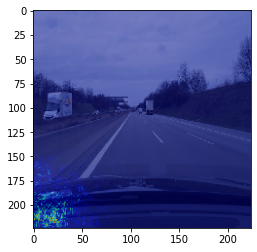

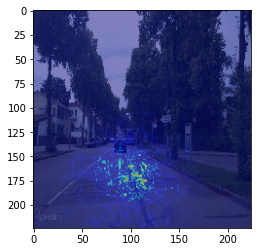

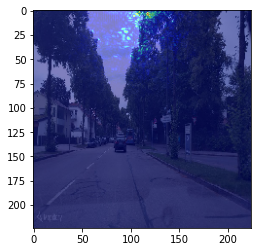

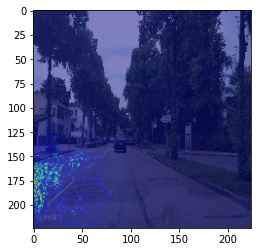

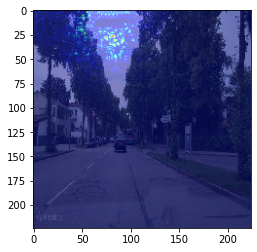

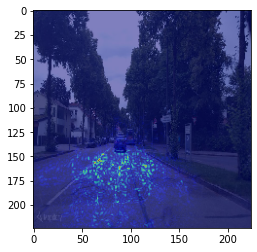

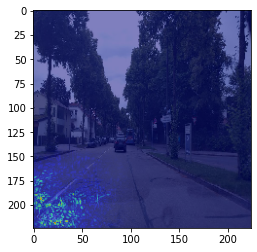

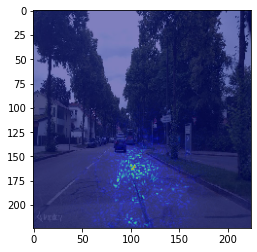

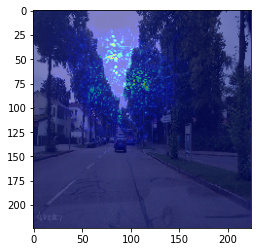

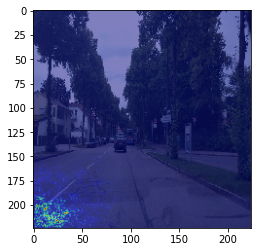

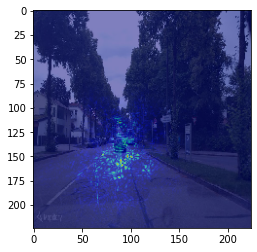

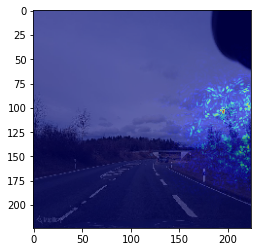

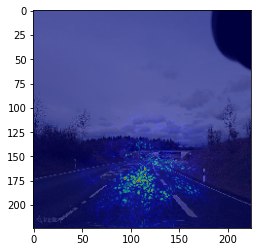

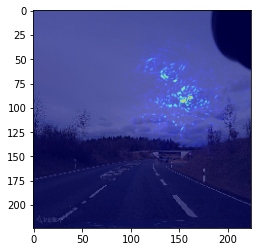

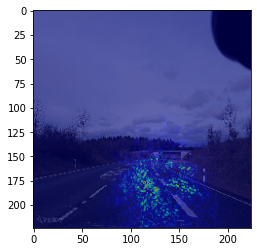

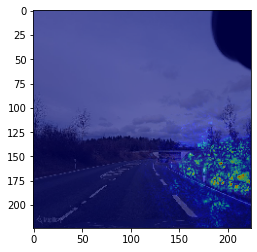

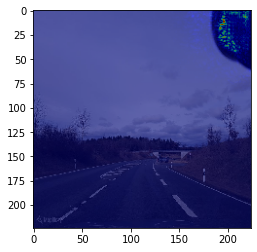

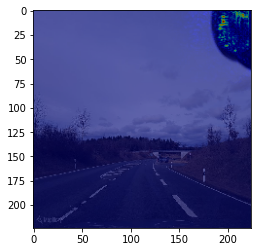

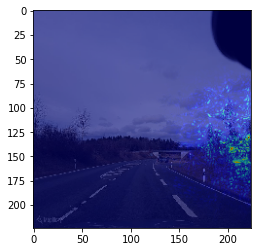

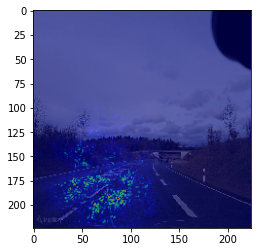

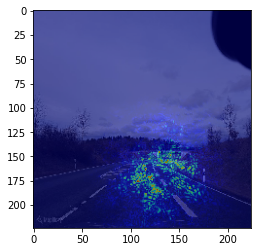

In [15]:
for image_filename in os.listdir(folder)[-3:]:
    img_path = os.path.join(folder , image_filename)
    img = image.load_img(img_path, target_size=(224, 224))

    images = tf.Variable([np.array(img)], dtype=float)

    with tf.GradientTape(persistent=True) as tape:
        pred = model(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]

        # Show the reason for the largest N features
        for i in range(10):
            loss = pred[0][class_idxs_sorted[i]]

            grads = tape.gradient(loss, images)

            dgrad_abs = tf.math.abs(grads)
            dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

            ## normalize to range between 0 and 1
            arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
            grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

            plt.imshow(img)
            plt.imshow(grad_eval, cmap='jet', alpha=0.5)
            plt.show()